# Threshold statistics

read in the threshold data all the simulations for the various GWLs and compute
median, 10 and 90%


In [1]:
import sys
import os

import intake
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [2]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client()
client

2024-07-24 09:56:18,189 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-07-24 09:56:18,191 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-07-24 09:56:18,207 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-clx-0143.gadi.nci.org.au/64705/proxy/8787/status,
Dashboard: /node/gadi-cpu-clx-0143.gadi.nci.org.au/64705/proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40747,Workers: 24
Dashboard: /node/gadi-cpu-clx-0143.gadi.nci.org.au/64705/proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44557,Total threads: 1
Dashboard: /node/gadi-cpu-clx-0143.gadi.nci.org.au/64705/proxy/40185/status,Memory: 0 B
Nanny: tcp://127.0.0.1:35117,


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# List of periods and variables
periods = ['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0']
base_period = 'GW1p2'

data_path = '/g/data/ia39/ncra/fire/'
mRuns = sorted(glob.glob(data_path + '*threshold.nc'))
nmodels=int(len(mRuns)/4)
print(len(mRuns),nmodels)
#print(mRuns)

48 12


In [5]:
# Load datasets and store in dict (works but I struggled to get into xarray)
thresholds = {}
var=['days50','days75','days100']
i=-1
for m in range(0,nmodels):
    p=-1
    for period in periods: #mRuns:
        i=i+1; p=p+1
#        print(m,p,i)
        ds=xr.open_dataset(mRuns[i])
        data=ds[var]
        thresholds[(m,period)]=data

d1=thresholds[0,periods[0]]
d2=thresholds[0,periods[1]]
d3=thresholds[0,periods[2]]
d4=thresholds[0,periods[3]]
thresholds[0,base_period]


<xarray.Dataset> Size: 15MB
Dimensions:  (lat: 691, lon: 886)
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Data variables:
    days50   (lat, lon) float64 5MB ...
    days75   (lat, lon) float64 5MB ...
    days100  (lat, lon) float64 5MB ...

In [6]:
%%time
i=-1
for m in range(0,nmodels):
    p=-1
    for period in periods: #mRuns:
        i=i+1; p=p+1
#        print(m,p)
        ds=xr.open_dataset(mRuns[i])
        if p == 0:
          d1=ds.expand_dims(model=[m],period=[p])
        elif p == 1:
          d2=ds.expand_dims(model=[m],period=[p])
        elif p == 2: 
          d3=ds.expand_dims(model=[m],period=[p])
        elif p == 3 :
          d4=ds.expand_dims(model=[m],period=[p])
    dtmp=xr.combine_by_coords([d1,d2,d3,d4])
    if m == 0:
        dall=dtmp
    else:
        dall = xr.combine_by_coords([dall,dtmp])

dall

CPU times: user 3.96 s, sys: 2.96 s, total: 6.92 s
Wall time: 8.7 s


<xarray.Dataset> Size: 705MB
Dimensions:  (model: 12, period: 4, lat: 691, lon: 886)
Coordinates:
  * model    (model) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * period   (period) int64 32B 0 1 2 3
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Data variables:
    days50   (model, period, lat, lon) float64 235MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days75   (model, period, lat, lon) float64 235MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    days100  (model, period, lat, lon) float64 235MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [7]:
dall.days100[:,:,:,:].max(axis=(2,3)).values

array([[ 7.8 , 12.35, 12.3 , 17.35],
       [12.45, 16.6 , 17.65, 27.1 ],
       [ 9.95, 15.1 , 20.5 , 22.2 ],
       [ 9.6 , 17.7 , 23.3 , 29.85],
       [19.  , 25.6 , 25.85, 27.  ],
       [13.25, 13.4 , 15.3 , 23.45],
       [11.6 , 15.5 , 14.65, 22.7 ],
       [21.4 , 24.4 , 37.25, 51.95],
       [17.5 , 26.1 , 25.7 , 35.9 ],
       [ 5.8 ,  9.55, 10.65, 10.85],
       [11.15, 12.1 , 13.1 , 17.85],
       [ 6.35, 12.85, 17.85, 17.55]])

In [10]:
ddif100=dall.days100[:,:,:,:]-dall.days100[:,0,:,:]
ddif75=dall.days75[:,:,:,:]-dall.days75[:,0,:,:]
ddif50=dall.days50[:,:,:,:]-dall.days50[:,0,:,:]
ddif100[:,:,:,:].max(axis=(2,3)).values

array([[ 0.  ,  5.05,  5.9 , 10.3 ],
       [ 0.  ,  4.5 ,  7.2 , 15.2 ],
       [ 0.  ,  6.15, 11.4 , 12.65],
       [ 0.  ,  9.25, 14.9 , 21.1 ],
       [ 0.  ,  7.85, 10.3 , 12.7 ],
       [ 0.  ,  4.3 ,  6.5 , 14.5 ],
       [ 0.  ,  4.6 ,  6.55, 13.65],
       [ 0.  ,  4.5 , 17.4 , 31.8 ],
       [ 0.  ,  9.65, 10.05, 20.2 ],
       [ 0.  ,  3.95,  6.45,  6.1 ],
       [ 0.  ,  1.65,  2.55,  7.  ],
       [ 0.  ,  6.5 , 12.55, 12.55]])

In [11]:
ddif100.median(axis=(0)).max(axis=(1,2)).values

array([ 0.   ,  4.125,  6.425, 12.45 ])

In [15]:
ddif100.median(axis=(0)).to_netcdf('/g/data/ia39/ncra/fire/change_threshold_100.nc')
ddif75.median(axis=(0)).to_netcdf('/g/data/ia39/ncra/fire/change_threshold_75.nc')
ddif50.median(axis=(0)).to_netcdf('/g/data/ia39/ncra/fire/change_threshold_50.nc')

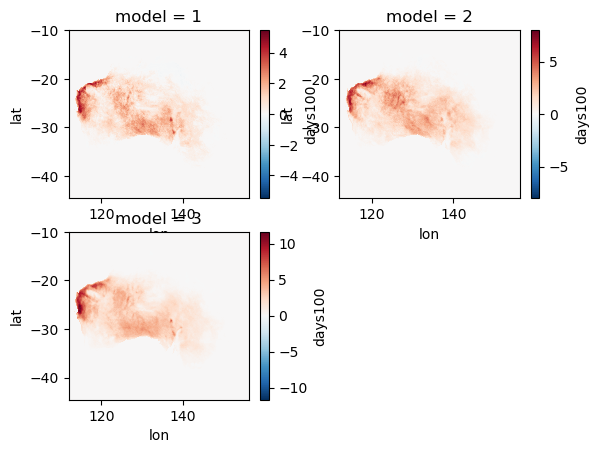

In [16]:
plt.subplot(2,2,1); ddif100[1,:,:].median(axis=(0)).plot()
plt.subplot(2,2,2); ddif100[2,:,:].median(axis=(0)).plot()
plt.subplot(2,2,3); ddif100[3,:,:].median(axis=(0)).plot()